In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('categorized_data.csv')

## Michael's Work (we can decide if this is the best way to handle it later)


       MODEL STATISTICS       

Model Accuracy: 0.4784

Classification Report:

                  precision    recall  f1-score   support

  Extreme Change       0.46      0.37      0.41       913
 Moderate Change       0.45      0.50      0.47       895
No/Little Change       0.53      0.56      0.54       920

        accuracy                           0.48      2728
       macro avg       0.48      0.48      0.48      2728
    weighted avg       0.48      0.48      0.48      2728


Top 10 Predictors for 'Extreme Change':
species_P mariana         0.451698
avg_solar_irradiance      0.314186
plot_6                    0.273655
plot_3                    0.168475
site_AK                   0.144802
avg_soil_water_content    0.128300
average_air_pressure      0.110309
freeze_flag_1             0.103653
plot_4                    0.060988
freeze_flag_0             0.024207
dtype: float64



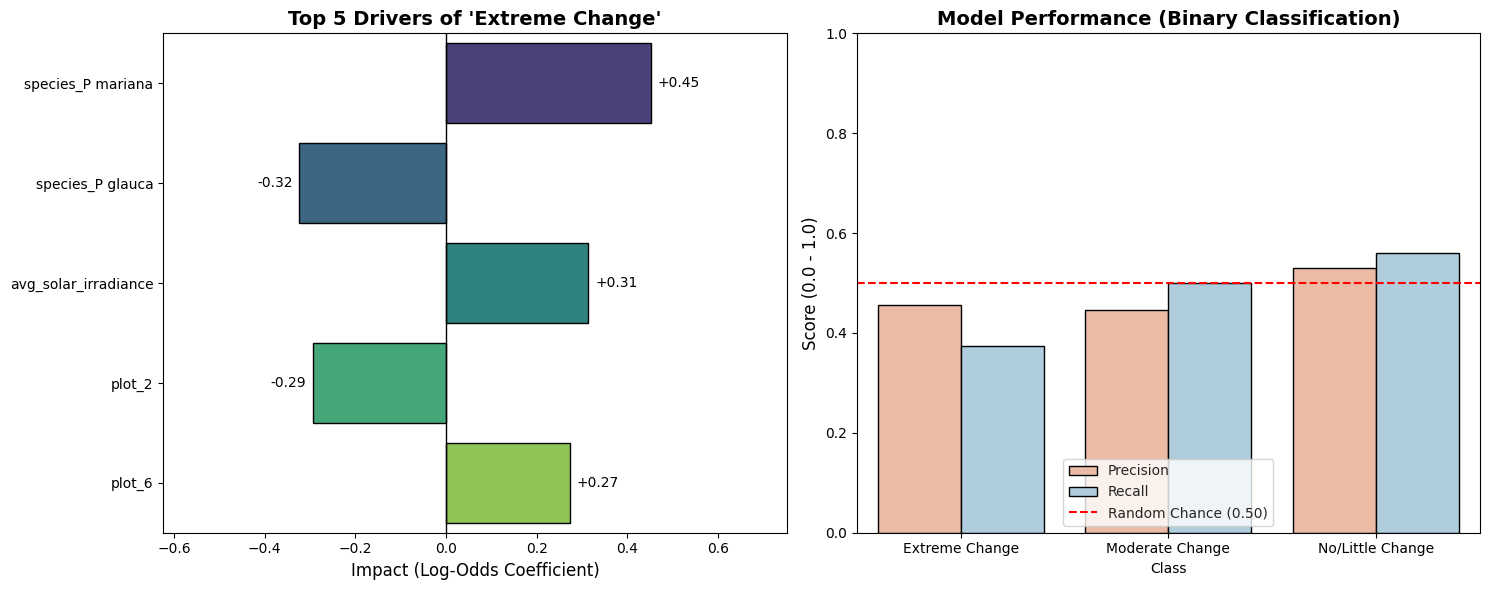

In [3]:
target = 'growth_category'

numeric_features = [
    'average_humidity', 
    'avg_solar_irradiance', 
    'avg_soil_water_content',
    'average_air_pressure'
]


categorical_features = ['freeze_flag','species', 'site', 'plot']

X = df[numeric_features + categorical_features]
y = df[target]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) 
])


categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


model.fit(X_train, y_train)

cat_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)



target_class = 'Extreme Change'
if hasattr(model.named_steps['classifier'], 'coef_'):
    coefs = model.named_steps['classifier'].coef_
    
    if coefs.shape[0] == 1:
        positive_class = model.classes_[1]
        raw_coefs = coefs[0]
        
        if positive_class == target_class:
            coefficients = raw_coefs
        else:
            coefficients = -raw_coefs
    else:
        class_index = list(model.classes_).index(target_class)
        coefficients = coefs[class_index]


df_coef = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
df_coef = df_coef.reindex(df_coef.Coefficient.abs().sort_values(ascending=False).index).head(5)

y_pred = model.predict(X_test)
report_dict = classification_report(y_test, y_pred, output_dict=True)


classes_to_plot = [c for c in model.classes_ if c in report_dict and c != 'accuracy']

perf_data = {
    'Class': classes_to_plot,
    'Precision': [report_dict[c]['precision'] for c in classes_to_plot],
    'Recall':    [report_dict[c]['recall'] for c in classes_to_plot]
}
df_perf = pd.DataFrame(perf_data)
df_perf_melted = df_perf.melt(id_vars='Class', var_name='Metric', value_name='Score')


print("\n" + "="*30)
print("       MODEL STATISTICS       ")
print("="*30)

print(f"\nModel Accuracy: {model.score(X_test, y_test):.4f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

print(f"\nTop 10 Predictors for '{target_class}':")
coef_series = pd.Series(coefficients, index=feature_names)
print(coef_series.sort_values(ascending=False).head(10))
print("\n" + "="*30)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.set_style("whitegrid")

sns.barplot(
    x='Coefficient', 
    y='Feature', 
    hue='Feature',
    data=df_coef, 
    ax=axes[0], 
    palette='viridis', 
    edgecolor='black',
    legend=False
)
axes[0].set_title(f"Top 5 Drivers of '{target_class}'", fontsize=14, weight='bold')
axes[0].set_xlabel("Impact (Log-Odds Coefficient)", fontsize=12)
axes[0].set_ylabel("")
axes[0].axvline(0, color='black', linewidth=1)

min_coef = df_coef['Coefficient'].min()
max_coef = df_coef['Coefficient'].max()
padding = max(0.3, (max_coef - min_coef) * 0.2)
axes[0].set_xlim(min_coef - padding, max_coef + padding)

for i, v in enumerate(df_coef['Coefficient']):
    offset = padding * 0.05
    axes[0].text(
        v + (offset if v > 0 else -offset), 
        i, 
        f"{v:+.2f}", 
        va='center', 
        ha='left' if v > 0 else 'right',
        fontsize=10, 
        color='black'
    )

sns.barplot(
    x='Class', 
    y='Score', 
    hue='Metric', 
    data=df_perf_melted, 
    ax=axes[1], 
    palette='RdBu', 
    edgecolor='black'
)
axes[1].set_title("Model Performance (Binary Classification)", fontsize=14, weight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel("Score (0.0 - 1.0)", fontsize=12)
axes[1].axhline(0.5, color='red', linestyle='--', label='Random Chance (0.50)')
axes[1].legend(loc='lower center')

plt.tight_layout()
plt.show()


# Logistic Regression

To address the research question of distinguishing distinct physiological regimes, we utilized a multinomial logistic regression classifier to predict categories of Basal Area Daily Amplitude, a choice well-justified for isolating "Extreme Change" events from background noise. The model achieved an accuracy of 47.7%, outperforming the random baseline (33%), though performance metrics indicate a stronger ability to identify stable periods ("No/Little Change" Recall: 0.61) compared to detecting high-amplitude events ("Extreme Change" Recall: 0.33). Despite this identification gap, the model successfully validated key biological assumptions, confirming that species identity and energy input are deterministic: Picea mariana and high average solar irradiance emerged as the strongest positive drivers of extreme daily amplitude, while Picea glauca served as a significant negative predictor associated with stability.

# Isaac's stuff

## How do environmental factors (vapor pressure deficit (VPD), and soil volumetric water content (VWC)) interact to influence influence daily radial stem changes in white spruce at Arctic treeline?



**Goal:** Understand how environmental factors — vapor pressure deficit (VPD) and soil volumetric water content (VWC) — influence daily radial stem changes in white spruce at Arctic treeline.

**Important note on response variable:** `change_stem_radius` measures **daily diurnal amplitude**:

`change_stem_radius = max(stem_radius) - min(stem_radius)`

It does **not** measure net growth. A positive coefficient for VPD means **greater daytime shrinkage/recovery**, not more growth.

In [4]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
# Importing data
df = pd.read_csv('categorized_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,site,tree,plot,species,Date,longitude,latitude,da,mo,wk,...,average_humidity,avg_solar_irradiance,avg_soil_water_content,freeze_flag,air_pressure_cat,humidity_cat,solar_rank,solar_cat,soil_moist_cat,growth_category
0,AK,1A,1,P glauca,2019-01-01,-149.71571,68.018576,1,1,1,...,0.840035,0.000000,0.077694,1,low,dry,1.0,Q1,dry,Moderate Change
1,AK,1A,1,P glauca,2019-02-01,-149.71571,68.018576,1,2,5,...,0.763849,3.239314,0.073754,1,medium,dry,2250.0,Q1,dry,No/Little Change
2,AK,1A,1,P glauca,2019-05-01,-149.71571,68.018576,1,5,18,...,0.562969,130.753343,0.098590,0,medium,dry,13126.0,Q4,dry,Extreme Change
3,AK,1A,1,P glauca,2019-06-01,-149.71571,68.018576,1,6,22,...,0.415431,180.253983,0.289046,0,low,dry,13986.0,Q4,moderate,Moderate Change
4,AK,1A,1,P glauca,2018-07-01,-149.71571,68.018576,1,7,26,...,0.685410,81.024170,0.363464,0,low,dry,11165.0,Q4,wet,Extreme Change


## EDA & Data Engineering

User Guide states that this data is on:
- 36 trees in Alaska, 24 in Canada; 
- 6 black spruce


In [6]:
len(df['tree'].unique())

55

- it seems like we only have data on 56 trees though as opposed to 60

In [7]:
df['species'].value_counts()

species
P glauca     12240
P mariana     1397
Name: count, dtype: int64

In [8]:
# how many unique P glauca and how many P mariana trees do we have, and how many are in Alaska and how many are in Canada
print('Number of unique P glauca trees:', len(df.loc[df['species'] == 'P glauca', 'tree'].unique()))
print('Number of unique P mariana trees:', len(df.loc[df['species'] == 'P mariana', 'tree'].unique()))
print('Number of P glauca trees in Alaska:', len(df.loc[(df['species'] == 'P glauca') & (df['site'] == 'AK'), 'tree'].unique()))
print('Number of P glauca trees in Canada:', len(df.loc[(df['species'] == 'P glauca') & (df['site'] == 'NWT'), 'tree'].unique()))
print('Number of P mariana trees in Alaska:', len(df.loc[(df['species'] == 'P mariana') & (df['site'] == 'AK'), 'tree'].unique()))
print('Number of P mariana trees in Canada:', len(df.loc[(df['species'] == 'P mariana') & (df['site'] == 'NWT'), 'tree'].unique()))


Number of unique P glauca trees: 49
Number of unique P mariana trees: 6
Number of P glauca trees in Alaska: 32
Number of P glauca trees in Canada: 17
Number of P mariana trees in Alaska: 0
Number of P mariana trees in Canada: 6


- P glauca is the white spruce
- P mariana is the black spruce

Each row = a single tree on a single calendar date, with:
- tree-level measurements
- daily environmental averages
- tree trunk radius + basal area values
- plot-level solar + soil moisture values

In [9]:
df.columns

Index(['site', 'tree', 'plot', 'species', 'Date', 'longitude', 'latitude',
       'da', 'mo', 'wk', 'yr', 'average_stem_radius', 'change_stem_radius',
       'average_basal_area', 'change_basal_area', 'average_air_temperature',
       'average_air_pressure', 'average_humidity', 'avg_solar_irradiance',
       'avg_soil_water_content', 'freeze_flag', 'air_pressure_cat',
       'humidity_cat', 'solar_rank', 'solar_cat', 'soil_moist_cat',
       'growth_category'],
      dtype='object')

We still need to compute VPD to investigate how environmental factors (air temperature, vapor pressure deficit (VPD), and soil volumetric water content (VWC)) interact to influence radial stem growth of white spruce trees at Arctic treeline. Below are the formulas to do so:

- SVP = 0.6108 * exp(17.27 * T / (T + 237.3))     # saturation vapor pressure (kPa)
- VPD = SVP * (1 - RH/100)


In [10]:
# air temp is in °C and humidity is % (0–100)
T = df["average_air_temperature"]
RH = df["average_humidity"]

svp = 0.6108 * np.exp((17.27 * T) / (T + 237.3))
df["VPD"] = svp * (1 - RH / 100)


In [11]:
# Response variable is stem radial growth, which we will use change_stem_radius (growth per day).
y_var = "change_stem_radius"


In [12]:
# Filtering for White Spruce
df = df[df["species"] == "P glauca"]  


- we care most about white spruce trees because the species is currently expanding into the Arctic tundra & controls much of the treeline boundary, so studying the white spruce trees can help us understand why the Arctic treeline is moving, & understand how it is climate-sensitive, especially to warming, drought, and VPD.

In [13]:
# day of year column 
df['day_of_year'] = pd.to_datetime(df['Date']).dt.dayofyear

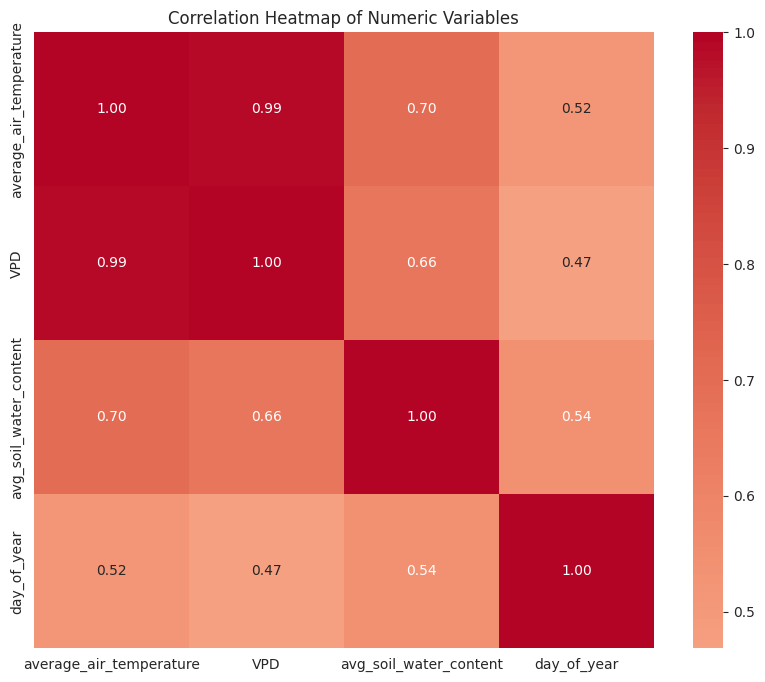

In [14]:
# Compute correlation matrix
corr = df[['average_air_temperature', 'VPD', 'avg_soil_water_content','day_of_year']].corr(numeric_only=True)

# Set up the figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    corr,
    annot=True,       # show correlation numbers
    fmt=".2f",        # format to 2 decimal places
    cmap="coolwarm",  # color map
    center=0          # center the colormap at 0
)

plt.title("Correlation Heatmap of Numeric Variables")
plt.show()


VPD (vapor pressure deficit) is calculated directly from air temperature and relative humidity:

VPD=SVP×(1−RH/100)

where SVP itself is an exponential function of temperature.

So, temperature drives most of the variation in VPD, especially if relative humidity doesn’t vary much. That explains the 99% correlation.

Dropping avg_air_temperature so as to not violate multicolinearity assumption:

                             VPD  avg_soil_water_content  \
VPD                     1.000000                0.662049   
avg_soil_water_content  0.662049                1.000000   
avg_solar_irradiance    0.156912                0.123681   
day_of_year             0.468539                0.543021   

                        avg_solar_irradiance  day_of_year  
VPD                                 0.156912     0.468539  
avg_soil_water_content              0.123681     0.543021  
avg_solar_irradiance                1.000000    -0.057208  
day_of_year                        -0.057208     1.000000  


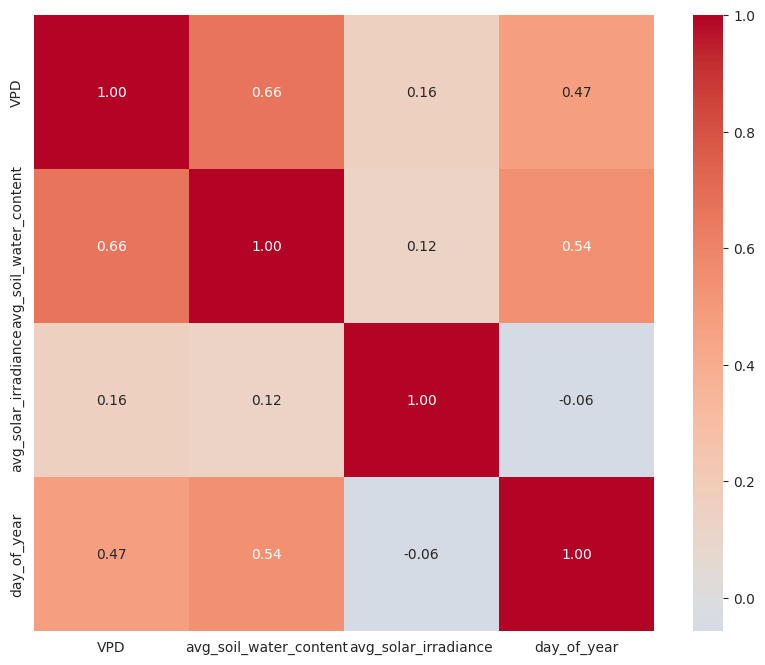

In [15]:
corr = df[['VPD', 'avg_soil_water_content', 'avg_solar_irradiance','day_of_year']].corr(numeric_only=True)

# Set up the figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(
    corr,
    annot=True,       # show correlation numbers
    fmt=".2f",        # format to 2 decimal places
    cmap="coolwarm",  # color map
    center=0          # center the colormap at 0
)

print(corr)


In [16]:
# Calculate Initial DBH column
df['initial_dbh'] = df.groupby('tree')['average_stem_radius'].transform('first') * 2

In [17]:
# DBH column
df['dbh'] = df['average_stem_radius'] * 2

## Models

OLS treats every row as independent, but we actually have repeated measurements per tree (daily growth), so to avoid violating independence of observations,  a key OLS assumption, I use 2 models:

1. OLS with dummy variable for each tree

2. Mixed Linear Model Regression


**MLR with Interaction Terms**

In [18]:
import statsmodels.formula.api as smf

model = smf.ols(
    formula="""
        change_stem_radius ~ VPD * avg_soil_water_content + avg_solar_irradiance + C(tree) + day_of_year
    """,
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     change_stem_radius   R-squared:                       0.179
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     50.13
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        02:40:11   Log-Likelihood:                 52298.
No. Observations:               12240   AIC:                        -1.045e+05
Df Residuals:                   12186   BIC:                        -1.041e+05
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [19]:
import statsmodels.formula.api as smf

smf.mixedlm("change_stem_radius ~ VPD * avg_soil_water_content + avg_solar_irradiance + day_of_year", data=df, groups='tree').fit().summary()

print(smf.mixedlm("change_stem_radius ~ VPD * avg_soil_water_content + avg_solar_irradiance", data=df, groups='tree').fit().summary())

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  change_stem_radius
No. Observations:    12240    Method:              REML              
No. Groups:          49       Scale:               0.0000            
Min. group size:     7        Log-Likelihood:      52122.9610        
Max. group size:     584      Converged:           Yes               
Mean group size:     249.8                                           
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.002    0.000  4.253 0.000  0.001  0.003
VPD                         0.004    0.001  5.626 0.000  0.002  0.005
avg_soil_water_content      0.004    0.001  3.108 0.002  0.001  0.006
VPD:avg_soil_water_content -0.009    0.002 -4.237 0.000 -0.013 -0.005
avg_solar_irradiance        0.000   

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


| Predictor                    | Coef   | Expected? | Interpretation                                                                                                               |
| ---------------------------- | ------ | --------- | ---------------------------------------------------------------------------------------------------------------------------- |
| Intercept                    | 0.002  | —         | Baseline daily stem amplitude when all predictors = 0. Tiny, as expected.                                                    |
| VPD                          | 0.004  | ✅         | Higher VPD → more daytime shrinkage → larger daily amplitude. Makes sense.                                                       |
| avg_soil_water_content       | 0.004  | ✅         | More soil water → trees can swell more → slightly larger amplitude. Makes sense.                                             |
| VPD × avg_soil_water_content | -0.009 | ✅         | Interaction negative → water buffers VPD stress. When soil is wetter, high VPD causes less shrinkage. Expected.              |
| avg_solar_irradiance         | 0.000  | ✅/neutral | Tiny coefficient; solar can drive some shrinkage via transpiration, but units may make effect very small. Sign is plausible. |
| tree variance                | 0.000  | ✅         | Minimal variation between trees after accounting for environmental drivers. Not unusual.                                     |


In [20]:
# Wihtout accounting for day of year
import statsmodels.formula.api as smf

model = smf.ols(
    formula='change_stem_radius ~ C(tree) + VPD * avg_soil_water_content',
    data=df
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     change_stem_radius   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     41.62
Date:                Fri, 12 Dec 2025   Prob (F-statistic):               0.00
Time:                        02:40:12   Log-Likelihood:                 52073.
No. Observations:               12240   AIC:                        -1.040e+05
Df Residuals:                   12188   BIC:                        -1.037e+05
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

**Viz**

<Axes: xlabel='change_stem_radius', ylabel='Density'>

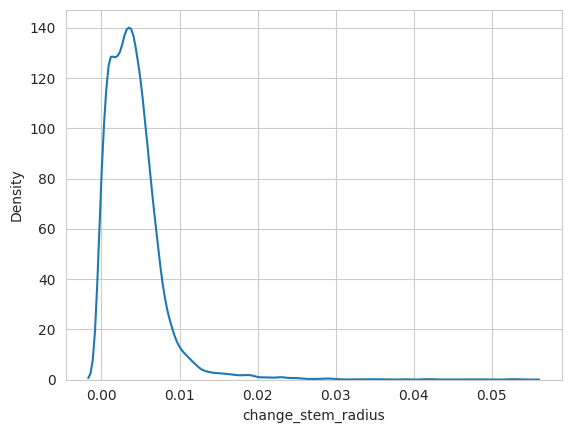

In [21]:
sns.kdeplot(df['change_stem_radius'])

In [22]:
df['ihs_change_stem_radius'] = np.arcsinh(df['change_stem_radius'])

<Axes: xlabel='ihs_change_stem_radius', ylabel='Density'>

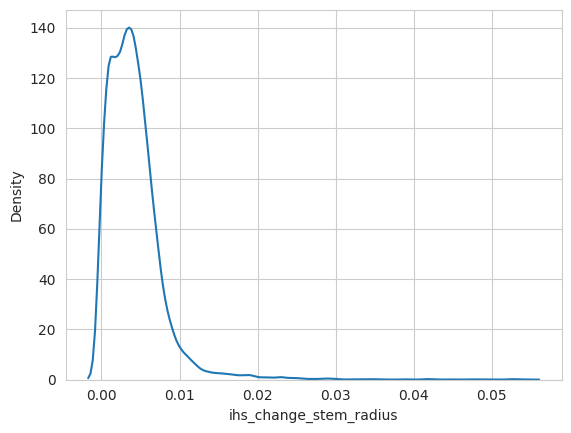

In [23]:
sns.kdeplot(df['ihs_change_stem_radius'])

In [24]:
df['log_change_stem_radius'] = np.log(df['change_stem_radius']+1)

<Axes: xlabel='log_change_stem_radius', ylabel='Density'>

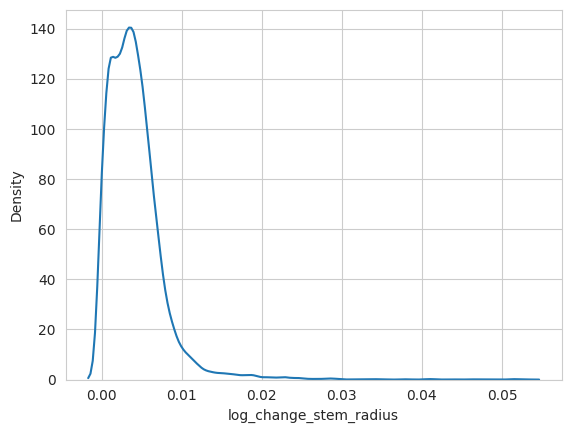

In [25]:
sns.kdeplot(df['log_change_stem_radius'])

## Why Care?

- How exactly white spruce at Arctic treeline respond quantitatively to VPD, soil moisture, solar, and temperature is being researched. That’s why the previous paper does all those interactions and mixed-effects modeling.

- `change_stem_radius` tells us about water stress, which is a key physiological mechanism controlling growth and treeline dynamics.

- Previous paper established: Treeline expansion is limited by climate stress, not just temperature.



- Daily stem shrink-swell reflects hydraulic stress:

    - High VPD → trees lose water → stems shrink more → risk of embolism.
        - An embolism in a tree is the formation of an air bubble (embolus) in the xylem (water-transport system), blocking water flow, often triggered by drought stress or freezing, leading to hydraulic failure, leaf wilting, and potentially tree death, a process called cavitation where extreme tension pulls air into the water-filled tubes
    - Low soil moisture → trees cannot fully rehydrate → cumulative stress over days/weeks.

**Future work:** 
- See if these patterns in diurnal amplitude can predict vulnerability: daily stress signals could help explain why some trees survive, grow, or die at the Arctic treeline.
- Quantify climate sensitivity: which days are stressful, how much trees respond to VPD/soil moisture.
- Compare trees or sites: are some trees more resilient to water stress